In [1]:
# import the packages we will need

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib as mpl
from scipy.stats import gamma
import importlib
! pip install fitter
from fitter import Fitter

# set plot aesthetics

medium_font = 10
plt.rc('axes', labelsize=medium_font)#, labelweight = 'bold')
sns.set_palette("mako")
mako = sns.color_palette()
lfs = 7 # legend font size
# modelled_dist_color = pal[3]

In [2]:
def get_dist(df, element):

  #https://medium.com/the-researchers-guide/finding-the-best-distribution-that-fits-your-data-using-pythons-fitter-library-319a5a0972e9
  #print(get_distributions())

  f = Fitter(df[f'{element}'].dropna(),
            distributions=['gamma'])

  f.fit()

  best_fit = f.get_best(method = 'sumsquare_error')
  dist_type = list(best_fit.keys())[0]

  a = best_fit[dist_type]['a']
  loc = best_fit[dist_type]['loc']
  scale = best_fit[dist_type]['scale']

  x = np.linspace(gamma.ppf(0.0000000000001, a, loc, scale),
                    gamma.ppf(0.999999999999, a, loc, scale), 1000000)
  rv = gamma(a, loc, scale)


  return rv.rvs(size = n)

In [3]:

def calc_element_conc(soil_d, feedstock_conc, soil_conc, dbd, t):
    '''
    DESCRIPTION: Modelling unrealistic worst-case scenario; everything but element of interest
    weathers and is transported away. Element of interest is immobile.

    INPUTS:

    soil_d = soil depth (m)
    soil_conc = concentration of element of interest in unamended soil (mg/kg)
    feedstock_conc = concentration of element of interest in feedstock (mg/kg)
    app_rate = application rate of the feedstock (kg/m2/y)
    dbd = soil bulk density (kg soil/m3)

    OUTPUTS:

    total_conc = total concentration of element of interest in soil (mg/kg)'''

    #total_conc_feedstock = (feedstock_conc * app_rate)/soil_d/dbd*t # pre 20241030 version
    total_conc_feedstock = (feedstock_conc * (t/10))/soil_d/dbd # now t = tonnes; t/10 is to convert from t/ha to kg/m2
    total_conc = total_conc_feedstock + soil_conc

    return total_conc

In [4]:
def get_thresh(df_thresh, element_short):

  rows_with_comma = df_thresh[df_thresh.map(lambda x: isinstance(x, str) and ',' in x).any(axis=1)]

  # Remove "<" and convert to float
  df_thresh['Threshold Level (mg/kg)'] = df_thresh['Threshold Level (mg/kg)'].apply(lambda x: x.replace(',', '') if isinstance(x, str) and ',' in x else x)

  thresh = df_thresh[df_thresh['Metal'] == f'{element_short}']['Threshold Level (mg/kg)'].dropna().astype('float').to_list()

  thresh_agency = df_thresh[df_thresh['Metal'] == f'{element_short}']['Agency'].to_list()

  return thresh, thresh_agency


In [5]:

def calc_conc(t, dbd_dist, soil_d_dist):

    total_conc_list = []

    over_thresh_basalt_soil_list = []
    over_thresh_basalt_feedstock_list = []
    over_thresh_peridotite_soil_list = []
    over_thresh_peridotite_feedstock_list = []

    for i in range(n):
        feedstock_conc = rng.choice(feedstock_dist, 1)[0]# pick a feedstock concentration
        soil_conc = rng.choice(soil_dist, 1)[0]# pick a soil conc
        dbd = rng.choice(dbd_dist, 1)[0]
        soil_d = rng.choice(soil_d_dist, 1)[0]

        if soil_d < 0:
            soil_d = 1

        total_conc = calc_element_conc(soil_d, feedstock_conc, soil_conc, dbd, t)
        total_conc_list.append(total_conc)

    return total_conc_list#, over_thresh_basalt_soil_dict, over_thresh_basalt_feedstock_dict, over_thresh_peridotite_soil_dict, over_thresh_peridotite_feedstock_dict

In [6]:
# --- TWO SUBPLOT VERSION ---


sns.set_palette("mako")
pal = sns.color_palette()

def make_plots(df, df_soil, feedstock_dist, soil_dist, element, element_short):

  fig, axes = plt.subplots(2, 1, figsize = (12, 6), sharex = True)

  # --- FEEDSTOCK DISTRIBUTION ---
  sns.histplot(df[f'{element}'].dropna(), kde=False, stat="density", label = 'GEOROC', color = mako[4], alpha = 0.6, ax=axes[0])
  sns.kdeplot(feedstock_dist, color = mako[4], lw=2, alpha=1, label=f'Feedstock distribution', ax=axes[0])

  axes[0].set_title(f'Feedstock and soil {element_short} distributions')


    # --- SOIL DISTRIBUTION ---
  sns.histplot(df_soil[f'{element}'].dropna(), kde=False, stat="density", label = 'Soil data', color = 'black', alpha = 0.6, ax = axes[0])
  sns.kdeplot(soil_dist, color = 'black', lw=2, alpha=1, label=f'Soil distribution', ax = axes[0])

  axes[0].legend(loc = 'upper right', fontsize = lfs)
  axes[0].set_xlabel(f'{element} concentration (mg/kg)')

  axes[0].set_xlim(0, np.percentile(feedstock_dist, 100))

    # --- POST-APP KDE ---

  #t_list = list(range(0, 12, 2)) # pre 20241030 version; t = years
  if feedstock_type == 'basalt':
    t_list = list(range(0, 126, 25)) # t = tonnes
  elif feedstock_type == 'peridotite':
    t_list = list(range(0, 26, 5)) # t = tonnes

  for t in t_list:
      total_conc_list = calc_conc(t, dbd_dist, soil_d_dist)

    #   if len(thresh) > 0:
    #     pct_above_25_thresh.append((sum(1 for x in total_conc_list if float(x) > threshold_val) / n)*100)
    #     pct_above_50_thresh.append((sum(1 for x in total_conc_list if float(x) > threshold_val) / n)*100)
    #     pct_above_75_thresh.append((sum(1 for x in total_conc_list if float(x) > threshold_val) / n)*100)
      # sns.kdeplot(total_conc_list, label = f'{t*app_rate*10} t/ha', cut = 0, ax = axes[0,1]) # pre 20241030 version *10 to convert to t/ha
      if feedstock_type == 'peridotite':
        if t % 5 == 0: # every 5, make a plot
            sns.kdeplot(total_conc_list, label = f'{t} t/ha', cut = 0, ax = axes[1])
            #df_pct_over_25_thresh_peridotite.loc[len(df_pct_over_25_thresh_peridotite)] = [element_short, t, pct_above_25_thresh[-1]]

      elif feedstock_type == 'basalt':
        if t % 25 == 0: # every 25, make a plot
            sns.kdeplot(total_conc_list, label = f'{t} t/ha', cut = 0, ax = axes[1]) #
            #df_pct_over_25_thresh_basalt.loc[len(df_pct_over_25_thresh_basalt)] = [element_short, t, pct_above_25_thresh[-1]]

  axes[1].set_xlabel(f'{element} concentration (mg/kg)')
  #plt.axvline(min(thresh), color = 'black', ls = '--', alpha = 0.3, zorder = 1, label = 'Min threshold')
  xmin, xmax, ymin, ymax = axes[1].axis()

    # -- plot all thresholds --
    # for i in range(len(thresh)):
    #     axes[1].axvline(thresh[i], color = 'black', ls = '--', alpha = 0.3)

#   plt.axvline(max(thresh), color = 'black', ls = '--', label = 'Max threshold')
  axes[1].legend(fontsize = lfs)
  axes[1].set_title(f'Soil {element_short} after {feedstock_type} application')

  #axes[0,1].set_xlim(0, np.percentile(feedstock_dist, 99))
  axes[1].set_xlim(0, max(total_conc_list))

  plt.tight_layout()

  fig.savefig(f"{element_short}_{feedstock_type}_all_plots.png", dpi = 300)



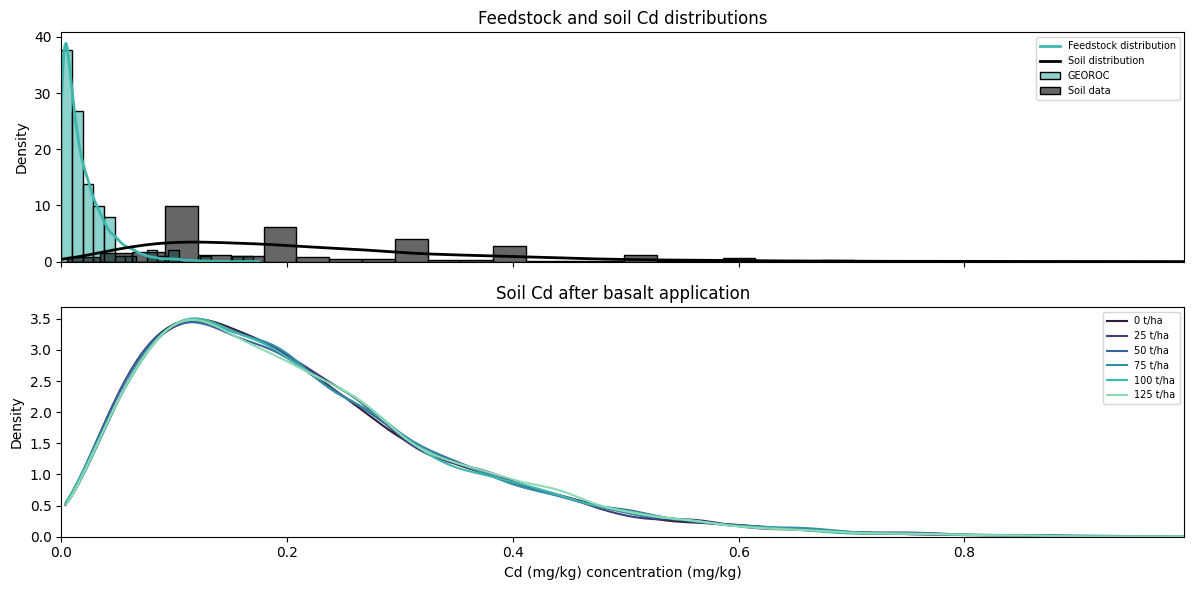

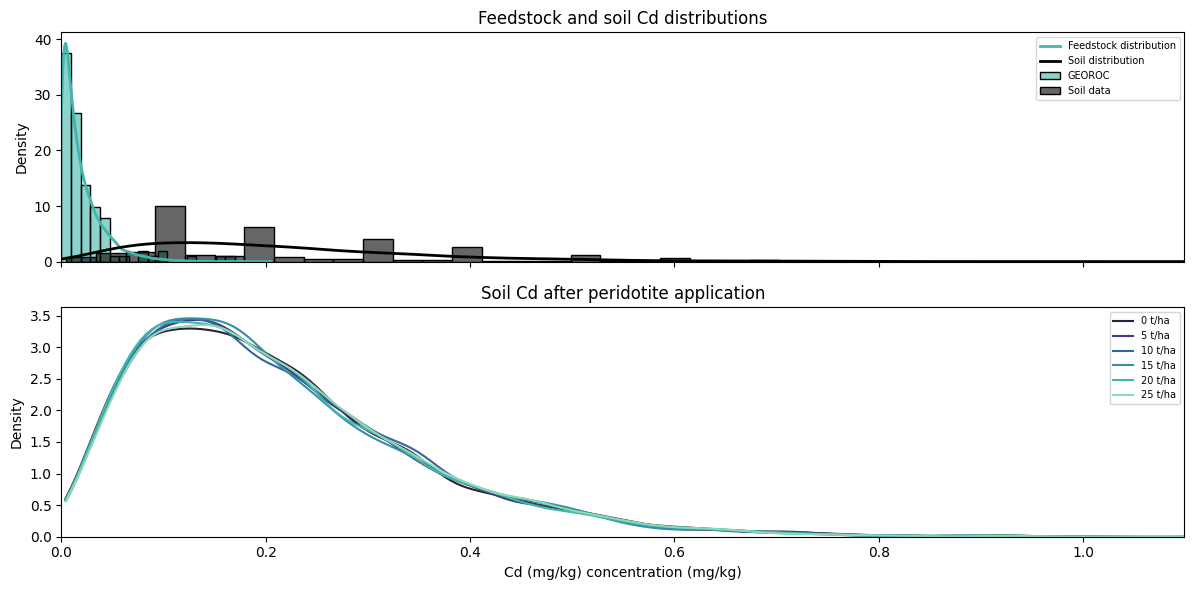

In [7]:
# FLOW CONTROL

# --- set constant values ---

soil_d_dist = np.random.uniform(0.05, 0.3, 10000)

# -- Calculate bulk density distribution
from scipy.stats import truncnorm

mean = 1250
std_dev = 250
a = 800  # Lower bound
b = 1700  # Upper bound

truncated_normal = truncnorm(
    (a - mean) / std_dev,  # Lower bound in standard normal space
    (b - mean) / std_dev,  # Upper bound in standard normal space
    loc=mean,              # Mean of the distribution
    scale=std_dev          # Standard deviation of the distribution
)

dbd_dist = truncated_normal.rvs(size=1000)  # Generate 1000 samples
n = 10000 # how many times to run
rng = np.random.default_rng()

# --- get data ---

df_soil = pd.read_csv('https://raw.githubusercontent.com/Cascade-Climate/metals/refs/heads/main/cleaned_soil_data.csv')
df = pd.read_csv('https://raw.githubusercontent.com/Cascade-Climate/metals/refs/heads/main/cleaned_feedstock_data.csv')
df_thresh = pd.read_csv('https://raw.githubusercontent.com/Cascade-Climate/metals/refs/heads/main/model_thresholds.csv')

# --- run model ---
for feedstock_type in ['basalt', 'peridotite']:

  if feedstock_type == 'basalt':

    elements = ['Ni', 'Cu', 'Zn', 'V', 'Pb', 'Co', 'Cd', 'Se', 'Cr', 'Mn', 'Sb',
            'Be', 'As', 'Ag', 'Ba', 'Hg']

  elif feedstock_type == 'peridotite':

    elements = ['Ni', 'Cu', 'Zn', 'V', 'Pb', 'Co', 'Cd', 'Se', 'Cr', 'Mn', 'Sb',
                'Be', 'As', 'Ag', 'Ba'] # NB no Hg because no peridotite Hg data!

  elements = ['Cd'] # FOR TESTING ON JUST ONE ELEMENT

  for element in elements:
    element_info = []
    element_short = element
    element = f'{element} (mg/kg)'

    feedstock_dist = get_dist(df, element)
    soil_dist= get_dist(df_soil, element)
    #thresh, thresh_agency = get_thresh(df_thresh, element_short)

    make_plots(df, df_soil, feedstock_dist, soil_dist, element, element_short)

    #files.download(f"{element_short}_{feedstock_type}_all_plots.png")

Text(0.5, 0, 'Metal concentration (mg/kg)')

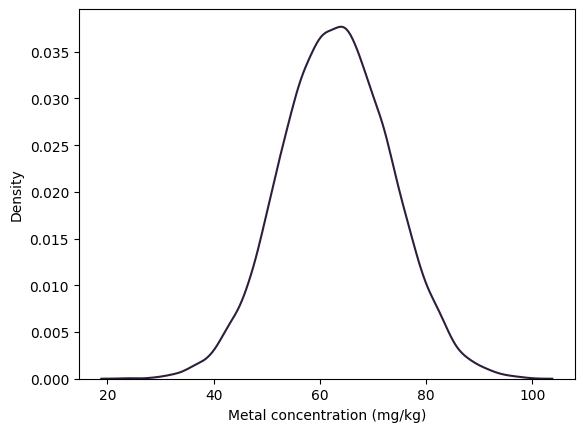

In [8]:
# CODE FOR USER-INPUT "CUSTOM" mode

from scipy.stats import truncnorm
from scipy.stats import norm

n = 10000
# USER INPUTS

cumulative_application = 20

feed_conc = 1500
feed_conc_SD = 250
rv = norm(loc=feed_conc, scale=feed_conc_SD)
feedstock_dist = rv.rvs(size = n)

soil_conc = 50
soil_conc_SD = 10
rv = norm(loc=soil_conc, scale=soil_conc_SD)
soil_dist = rv.rvs(size = n)

dbd = 1300
dbd_err = 100
rv = norm(loc=dbd, scale=dbd_err)
dbd_dist = rv.rvs(size = n)

soil_d = 0.18
soil_d_err = 0.02
rv = norm(loc=soil_d, scale=soil_d_err)
soil_d_dist = rv.rvs(size = n)

total_conc_list = calc_conc(cumulative_application, dbd_dist, soil_d_dist)

sns.kdeplot(total_conc_list)
plt.xlabel(f'Metal concentration (mg/kg)')

# THEN PLOT THRESHOLDS (from df_thresh) AGAINST THIS
#thresh, thresh_agency = get_thresh(df_thresh, element_short)